## Question 1: **Answer**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
def add_data_to_database(input_data):
    try:
        # Creating a DataFrame
        cars = pd.read_csv(input_data, encoding='unicode_escape')
        # Connecting to database
        engine = sqlite3.connect("secondhand_cars.db")
        cars.to_sql("cars", con=engine, index = False)
    except Exception as e:
            print(f"Error: {e}")

# Loading CSV file
data = "/content/secondhand_cars.csv"
add_data_to_database(data)

In [3]:
# Loading SQL extension
%load_ext sql

In [4]:
# Connecting to the database
%sql sqlite:///secondhand_cars.db

In [5]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [6]:
%%sql
SELECT * FROM cars LIMIT 10;

 * sqlite:///secondhand_cars.db
Done.


mileage,make,model,fuel,gear,offerType,price,hp,year
235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011
147000,Toyota,Auris,Electric/Gasoline,Automatic,Used,6950,99.0,2011
91894,Renault,Scenic,Diesel,Manual,Used,6970,131.0,2011
127500,Opel,Zafira,Gasoline,Manual,Used,6972,116.0,2011
115000,Mazda,3,Gasoline,Automatic,Used,6980,150.0,2011
104,Ford,Transit,Diesel,Manual,Used,6990,86.0,2011


## Question 1: **Answer**

In [7]:
%%sql
SELECT
    FIRST_VALUE(make || ' ' || model) OVER (ORDER BY price ASC)
    AS least_expensive_make,

    FIRST_VALUE(price) OVER (ORDER BY price ASC)
    AS least_expensive_make_price,

    LAST_VALUE(make || ' ' || model) OVER (
        ORDER BY price ASC
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS most_expensive_make,

    LAST_VALUE(price) OVER (
        ORDER BY price ASC
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) AS most_expensive_make_price

FROM cars
LIMIT 1;

 * sqlite:///secondhand_cars.db
Done.


least_expensive_make,least_expensive_make_price,most_expensive_make,most_expensive_make_price
Citroen C1,1100,Ferrari F12,1199900


## Question 3: **Answer**

In [8]:
%%sql
WITH average_price AS (
    -- Calculate the average car price
    SELECT AVG(price) AS avg_price
    FROM cars
)
SELECT
    -- Count of cars with price above 75% of the average price
    SUM(CASE WHEN price > 0.75 * avg_price THEN 1 ELSE 0 END)
    AS cars_above_75_avg,
    -- Count of cars with price below 25% of the average price
    SUM(CASE WHEN price < 0.25 * avg_price THEN 1 ELSE 0 END)
    AS cars_below_75_avg
FROM cars, average_price;

 * sqlite:///secondhand_cars.db
Done.


cars_above_75_avg,cars_below_75_avg
20615,1505


## Question 4: **Answer**

In [9]:
%%sql
WITH avg_price AS (
    -- Calculate the average car price
    SELECT AVG(price) AS avg_price
    FROM cars
    WHERE make = 'BMW'
)

SELECT
    -- Count of cars with price above 75% of the average price
    SUM(CASE WHEN price > (0.75 * avg_price) THEN price ELSE 0 END)
    AS count_of_cars_above_75_avg ,
    -- Count of cars with price below 75% of the average price
   SUM(CASE WHEN price < (0.75 * avg_price) THEN price ELSE 0 END)
    AS count_of_cars_below_25_avg
FROM cars, avg_price
WHERE make = 'BMW';

 * sqlite:///secondhand_cars.db
Done.


count_of_cars_above_75_avg,count_of_cars_below_25_avg
42688494,13645428


## Question 5: **Answer**

In [10]:
%%sql
-- Partition data by make and create a rank
WITH ranked_models AS (
    SELECT
        make,
        model,
        price,
        ROW_NUMBER() OVER (PARTITION BY make ORDER BY price DESC)
        AS price_rank
    FROM cars
    WHERE make IN ('BMW', 'Volkswagen', 'Audi', 'Mercedes-Benz')
)
-- Returning top ranked cars in each partition
SELECT
    make,
    model,
    price
FROM ranked_models
WHERE price_rank = 1;

 * sqlite:///secondhand_cars.db
Done.


make,model,price
Audi,R8,295000
BMW,M4,184450
Mercedes-Benz,S 650,717078
Volkswagen,Touareg,101880


## Creating a plot

In [11]:
query = """
WITH ranked_models AS (
    SELECT
        make,
        model,
        price,
        ROW_NUMBER() OVER (PARTITION BY make ORDER BY price DESC) AS price_rank
    FROM cars
    WHERE make IN ('BMW', 'Volkswagen', 'Audi', 'Mercedes-Benz')
)

SELECT
    make,
    model,
    price
FROM ranked_models
WHERE price_rank = 1;

"""

In [12]:
# Establishing a connection to the database
connection = sqlite3.connect("secondhand_cars.db")
# Creating a DataFrame
df = pd.read_sql_query(query, connection)

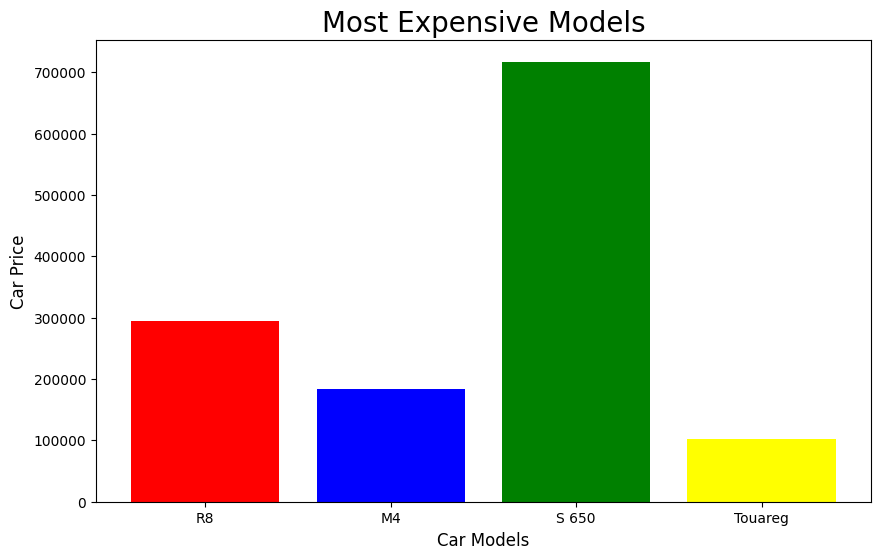

In [13]:
# Retrieving car models
car_models = df.loc[0:,'model']
# Retrieving car models prices
car_prices = df.loc[0:,'price']

# Creating a bar plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(car_models, car_prices,
       label = car_models,
       color = ['Red', 'Blue', 'Green', 'Yellow'])
ax.set_ylabel("Car Price", fontsize = 12)
ax.set_xlabel("Car Models", fontsize = 12)
plt.title("Most Expensive Models", fontsize = 20)
plt.show()
connection.close()

## Question 6: **Answer**

In [14]:
%%sql
-- Calculating average mileage
WITH model_avg_mileage AS (
    SELECT
        make,
        model,
        AVG(mileage) AS average_mileage
    FROM cars
    WHERE make IN ('BMW', 'Volkswagen', 'Audi', 'Mercedes-Benz')
    GROUP BY make, model
),
-- Identify the min average mileage for each make
min_avg_mileage AS (
    SELECT
        make,
        MIN(average_mileage) AS min_mileage
    FROM model_avg_mileage
    GROUP BY make
)
-- Retrieve car(s) with second lowest average
SELECT
    m.make,
    m.model,
    MIN(m.average_mileage) AS average_mileage
FROM model_avg_mileage m
JOIN min_avg_mileage mm
ON m.make = mm.make AND m.average_mileage > mm.min_mileage
ORDER BY m.average_mileage DESC;

 * sqlite:///secondhand_cars.db
Done.


make,model,average_mileage
Mercedes-Benz,S 650,90.0
